In [21]:
import pandas as pd
import numpy as np

from pathlib import Path

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import tfidf_weight, bm25_weight

from scipy.sparse import csr_matrix

from matplotlib import pyplot as plt

from metrics import precision_at_k, recall_at_k, ap_k, map_k

Поэкспериментировать с ALS (grid-search):

In [2]:
DATA = Path('../retail_train.csv')
data = pd.read_csv(DATA)

In [3]:
test_size_week = 3

data_test = data.loc[data.week_no > data.week_no.max() - test_size_week]
data_train = data.loc[data.week_no <= data.week_no.max() - test_size_week]

data_train.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [4]:
print('Новых пользователей:', len(set(data_test.user_id) - set(data_train.user_id)))

Новых пользователей: 0


In [5]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index().sort_values('quantity', ascending=False)
popularity = popularity.item_id.to_list()
results = data_test.groupby('user_id')['item_id'].unique().reset_index()

In [41]:
def fit(df, TOP=5000, pivot_by='quantity', factors=100, iterations=15, reg=0.001, draw=True):
    data_top = df.copy()

    data_top.loc[~data_top['item_id'].isin(popularity[:TOP]), 'item_id'] = 999999

    user_item_matrix = pd.pivot_table(data_top, 
                                      index='user_id', columns='item_id', 
                                      values=pivot_by, # Можно пробовать другие варианты
                                      aggfunc='count', 
                                      fill_value=0
                                     )

    user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

    # переведем в формат saprse matrix
    sparse_user_item = csr_matrix(user_item_matrix).tocsr()

    userids = user_item_matrix.index.values
    itemids = user_item_matrix.columns.values

    matrix_userids = np.arange(len(userids))
    matrix_itemids = np.arange(len(itemids))

    id_to_itemid = dict(zip(matrix_itemids, itemids))
    id_to_userid = dict(zip(matrix_userids, userids))

    itemid_to_id = dict(zip(itemids, matrix_itemids))
    userid_to_id = dict(zip(userids, matrix_userids))
    
    model = AlternatingLeastSquares(factors=factors,
                                    regularization=reg,
                                    iterations=iterations,
                                    calculate_training_loss=draw, 
                                    num_threads=0)

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=draw)

    recs = model.recommend_all(csr_matrix(user_item_matrix).tocsr(), N=5)
    
    return model, sparse_user_item, userid_to_id, id_to_itemid

def recs(user, model, sparse_user_item, userid_to_id, id_to_itemid, N=5):
    recs = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=False)]
    return recs

Непосредственно grid-search не выполнялся из-за медлительности вычислений машины, поэтому зависимости метрики от гиперпараметров построены отдельно друг от друга. Не исключено, что при кросс проверке могут быть выявлены какие-либо новые инсайты.

Далее графики отображены раньше, чем определены из-за достаточно объемной технической информации при рекомендациях.

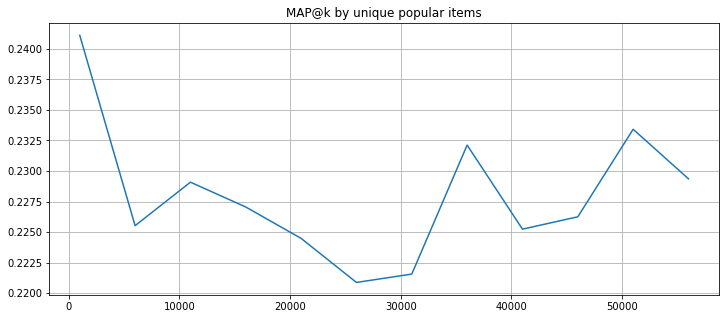

In [54]:
plt.figure(figsize=(12, 5))
plt.plot(scores.keys(), scores.values())
plt.title('MAP@k by unique popular items')
plt.grid()
plt.show()

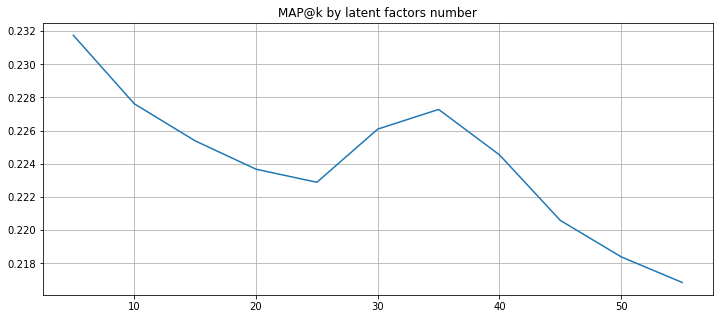

In [68]:
plt.figure(figsize=(12, 5))
plt.plot(scores_factors.keys(), scores_factors.values())
plt.title('MAP@k by latent factors number')
plt.grid()
plt.show()

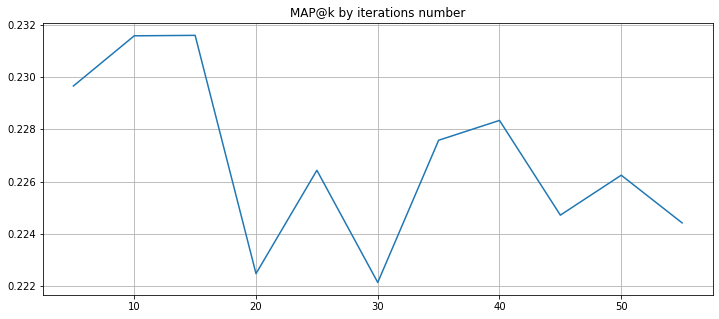

In [57]:
plt.figure(figsize=(12, 5))
plt.plot(scores_iter.keys(), scores_iter.values())
plt.title('MAP@k by iterations number')
plt.grid()
plt.show()

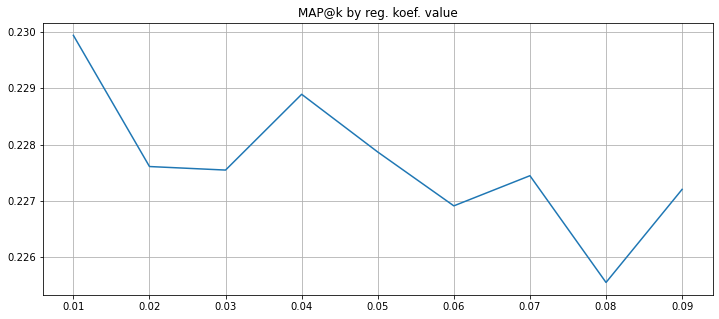

In [69]:
plt.figure(figsize=(12, 5))
plt.plot(scores_reg.keys(), scores_reg.values())
plt.title('MAP@k by reg. koef. value')
plt.grid()
plt.show()

Явной корреляции MAP@k тестовой выборки от гиперпараметров для ALM отдельно не выявлено, кроме зависимости количества латентных факторов, которая позволяет получить локальный максимум метрики при параметре $\approx35$.

In [19]:
%%time

scores = dict()

for i in range(1, 60, 5):
    model, sparse_user_item, userid_to_id, id_to_itemid = fit(data_train, i * 1000, factors=30, iterations=30)
    res_recs = results.user_id.apply(lambda x: recs(x, model, sparse_user_item, userid_to_id, id_to_itemid))
    score = map_k(res_recs, results.item_id)
    scores[i * 1000] = score
    print(i)


1



6



11



16



21



26



31



36



41



46



51



56
Wall time: 8min 43s


In [28]:
%%time

scores_factors = dict()

for i in range(5, 60, 5):
    model, sparse_user_item, userid_to_id, id_to_itemid = fit(data_train, TOP=10000, factors=i, iterations=30, draw=False)
    res_recs = results.user_id.apply(lambda x: recs(x, model, sparse_user_item, userid_to_id, id_to_itemid))
    score = map_k(res_recs, results.item_id)
    scores_factors[i] = score
    print(i)


5



10



15



20



25



30



35



40



45



50



55
Wall time: 3min 13s


In [30]:
%%time

scores_iter = dict()

for i in range(5, 60, 5):
    model, sparse_user_item, userid_to_id, id_to_itemid = fit(data_train, TOP=10000, factors=35, iterations=i, draw=False)
    res_recs = results.user_id.apply(lambda x: recs(x, model, sparse_user_item, userid_to_id, id_to_itemid))
    score = map_k(res_recs, results.item_id)
    scores_iter[i] = score
    print(i)


5



10



15



20



25



30



35



40



45



50



55
Wall time: 2min 47s


In [48]:
%%time

scores_reg = dict()

for i in range(10, 100, 10):
    model, sparse_user_item, userid_to_id, id_to_itemid = fit(data_train,
                                                              TOP=10000,
                                                              factors=35,
                                                              iterations=i,
                                                              reg=i / 1000,
                                                              draw=False)
    res_recs = results.user_id.apply(lambda x: recs(x, model, sparse_user_item, userid_to_id, id_to_itemid))
    score = map_k(res_recs, results.item_id)
    scores_reg[i / 1000] = score
    print(i)


10



20



30



40



50



60



70



80



90
Wall time: 4min 4s
